In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import itertools
import warnings

warnings.filterwarnings("ignore") 

## Reading and preprocessing the data


### Temperature anomaly: NASA GISTEMP Global Means (Land-Ocean Temperature Index, LOTI)

In [46]:
glb = read_csv('weather_data/GLB.Ts+dSST.csv', skiprows=1)
glb = glb[0:139]
glb.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
134,2014,0.72,.51,.75,.76,.85,.66,.55,.80,.88,.80,.65,.77,.73,.72,.63,.79,.67,.78
135,2015,0.81,.86,.89,.74,.75,.78,.71,.78,.81,1.06,1.02,1.10,.86,.83,.81,.79,.76,.97
136,2016,1.15,1.33,1.30,1.07,.90,.77,.81,1.00,.87,.89,.90,.83,.98,1.01,1.19,1.09,.86,.89
137,2017,0.97,1.12,1.12,.92,.88,.69,.82,.86,.75,.87,.85,.89,.90,.89,.97,.97,.79,.83
138,2018,0.77,.84,.91,.87,.81,.74,.78,.73,.75,.99,.78,.89,.82,.82,.83,.86,.75,.84


In [47]:
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb_formatted = preprocess_temp_anomaly(glb)
glb_formatted['anomaly'] = pd.to_numeric(glb_formatted.anomaly)
glb_formatted.head()

,anomaly
DateTime,
1880-01-01,-0.29
1880-02-01,-0.18
1880-03-01,-0.11
1880-04-01,-0.19
1880-05-01,-0.11


### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [48]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

maunaloa = read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

maunaloa['DateTime']  = pd.to_datetime(maunaloa.Year.map(str) + '-' + maunaloa.Month.map(str))
maunaloa = maunaloa.set_index(['DateTime'])

maunaloa.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-02-01,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


In [49]:
maunaloaFilled = maunaloa[['CO2filled', 'seasonalCO2filled']].copy()
maunaloaFilled.replace(to_replace=[-99.99], value=np.nan, inplace=True)

### The Oceanic Niño Index (ONI) 

In [51]:
enso = read_csv('weather_data/ONIindex.csv',delim_whitespace=True)

In [52]:
enso['DateTime'] = pd.to_datetime(enso.YR.map(str) + '-' + enso.MON.map(str))
enso = enso.set_index(['DateTime']) 

In [53]:
enso.head()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


### Sunspot Number

In [54]:
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)

In [55]:
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))

In [56]:
sunspots = sunspots.set_index(['DateTime'])  

In [57]:
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


### Range there is data of all the variables

In [58]:
#Choosing a range there is data of
anomalyrange = glb_formatted['1960-01-01' : '2018-12-01']
co2range = maunaloaFilled[['CO2filled']]['1960-01-01' : '2018-12-01']  #.CO2filled['1960-01-01' : '2018-12-01']
ensorange = enso[['ANOM']]['1960-01-01' : '2018-12-01']
spotsrange = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

In [59]:
anomalyrange.to_csv('gridsearch_data/anomalyrange.csv')
co2range.to_csv('gridsearch_data/co2range.csv')
ensorange.to_csv('gridsearch_data/ensorange.csv')
spotsrange.to_csv('gridsearch_data/spotsrange.csv')

In [60]:
exogenous = pd.concat([co2range,ensorange,spotsrange], axis=1)

In [61]:
exogenous.tail()

,CO2filled,ANOM,SNvalue
DateTime,,,
2018-08-01,407.10,0.04,8.7
2018-09-01,405.59,0.39,3.3
2018-10-01,405.99,0.86,4.9
2018-11-01,408.12,0.86,5.9
2018-12-01,409.23,0.84,3.1


## Plotting the data

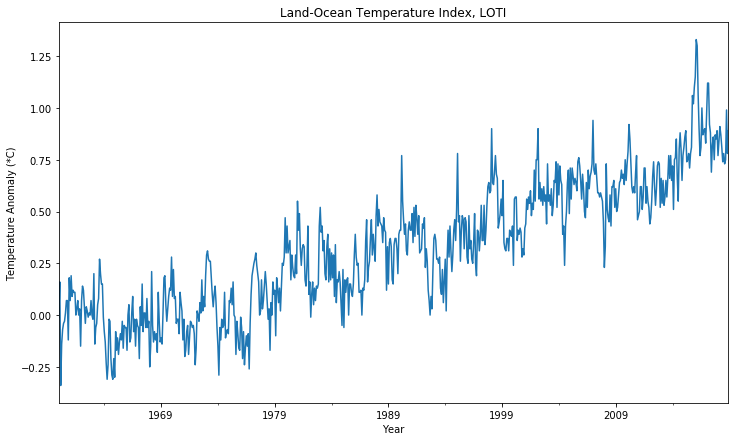

In [64]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
anomalyrange.anomaly.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (*C)')
plt.title('Land-Ocean Temperature Index, LOTI')
plt.show()


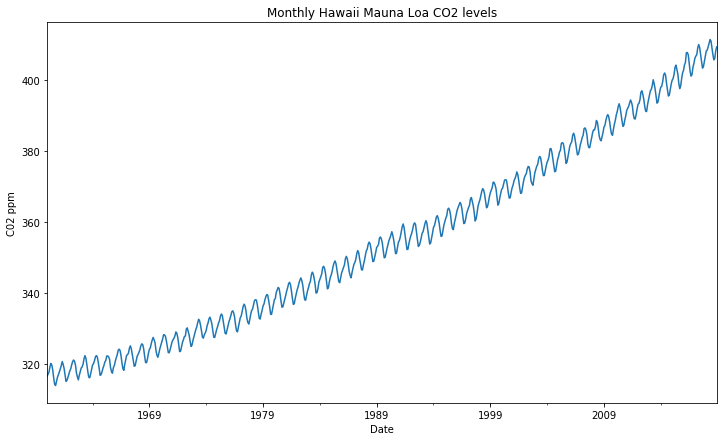

In [65]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
co2range.CO2filled.plot(ax=ax)

plt.xlabel('Date')
plt.ylabel('C02 ppm')
plt.title('Monthly Hawaii Mauna Loa CO2 levels')
plt.show()

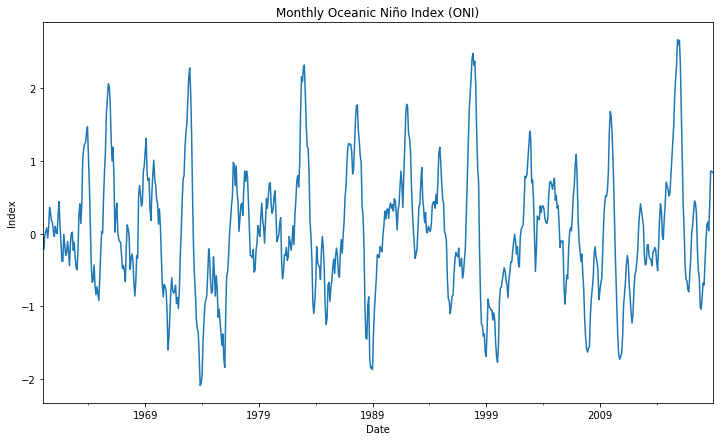

In [66]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ensorange.ANOM.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Monthly Oceanic Niño Index (ONI)')
plt.show()

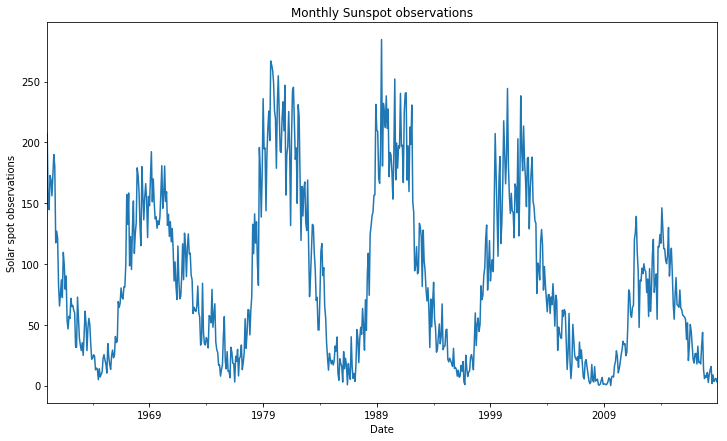

In [67]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
spotsrange.SNvalue.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Solar spot observations')
plt.title('Monthly Sunspot observations')
plt.show()

## Seasonal Decompositions

### Temperature anomaly

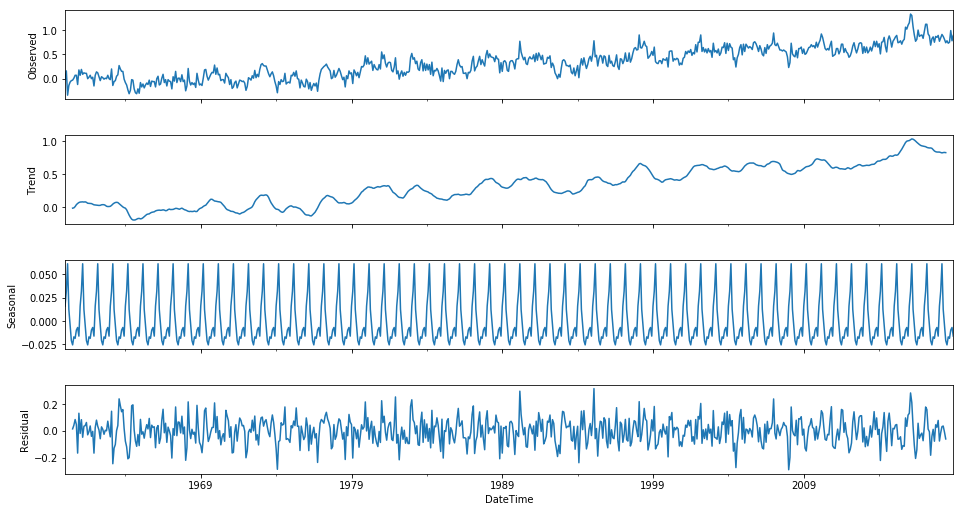

In [68]:
res = sm.tsa.seasonal_decompose(anomalyrange.anomaly,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Hawaii CO2 ppm 

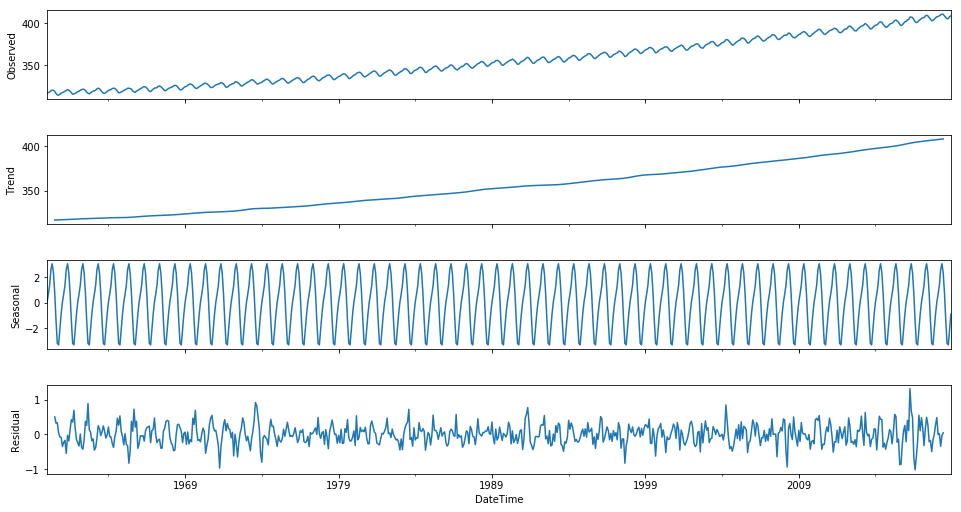

In [69]:
res = sm.tsa.seasonal_decompose(co2range.CO2filled,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### The Oceanic Niño Index (ONI)

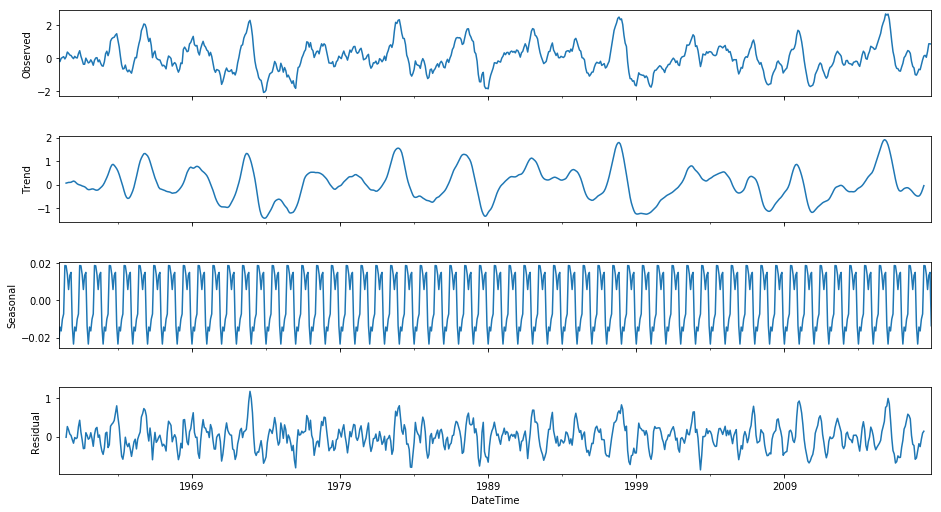

In [70]:
res = sm.tsa.seasonal_decompose(ensorange.ANOM,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Sunspot observations

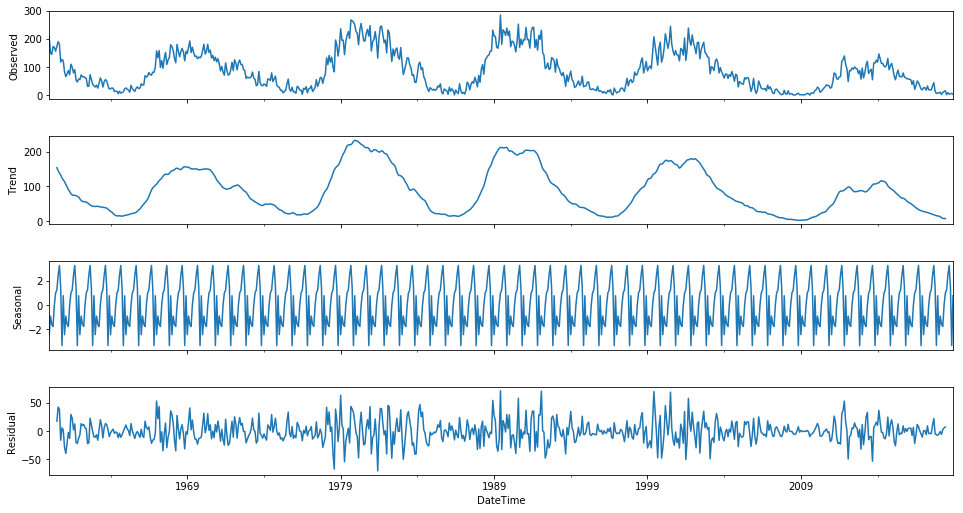

In [71]:
res = sm.tsa.seasonal_decompose(spotsrange.SNvalue,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Model Selection

In [72]:
#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

### Checking Stationarity (Trend)

#### Temperature anomaly

Temperature anomaly lacks identifiable seasonal trend, but has a constant trend

In [73]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# data does not have a unit root and is stationary

p-value:1.7226623111401798e-08


In [74]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.4945945470635184


#### Hawaii CO2 ppm 

CO2 concentration has both a seasonal and a constant trend

In [75]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.9885944880242227


In [76]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:1.0


#### The Oceanic Niño Index (ONI) and Sunspot observations

ONI and Sunspot observations have no trend

In [77]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:4.519555052443993e-08


In [78]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:2.5062854384841634e-09


In [79]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0030167208232305537


In [80]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0007375824522553518


### Correlograms

#### Temperature anomaly

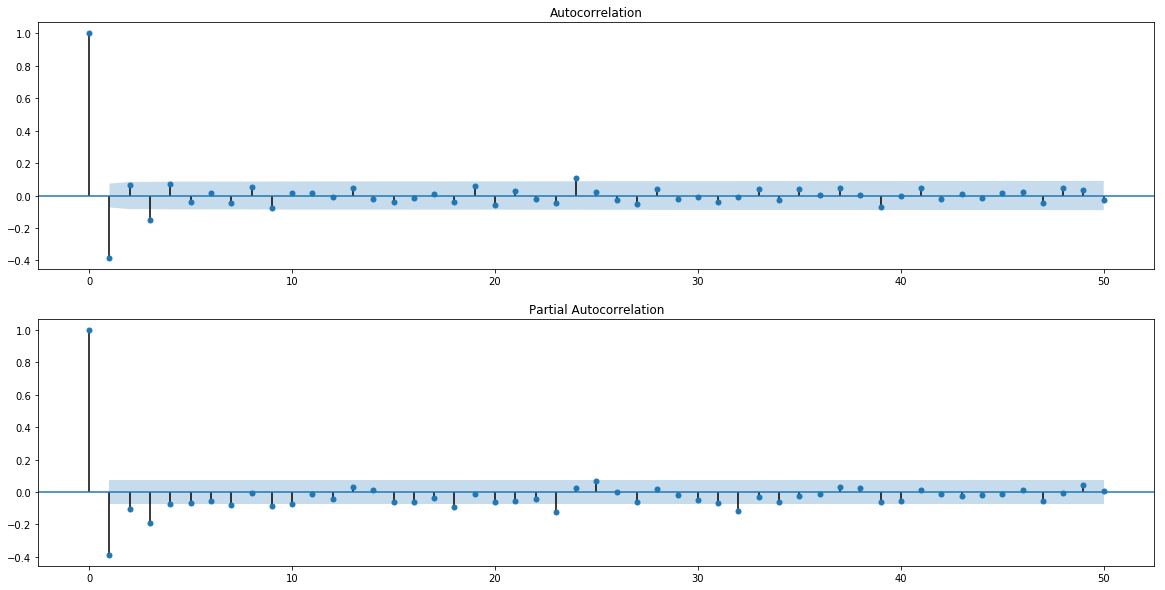

In [81]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### Hawaii CO2 ppm

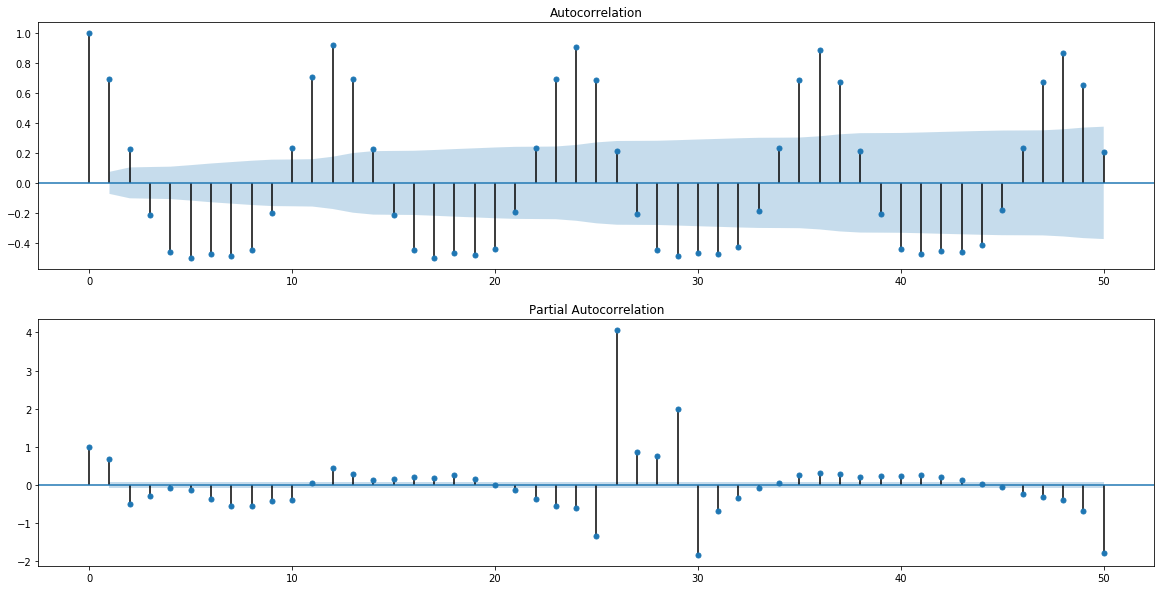

In [82]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### The Oceanic Niño Index (ONI) 

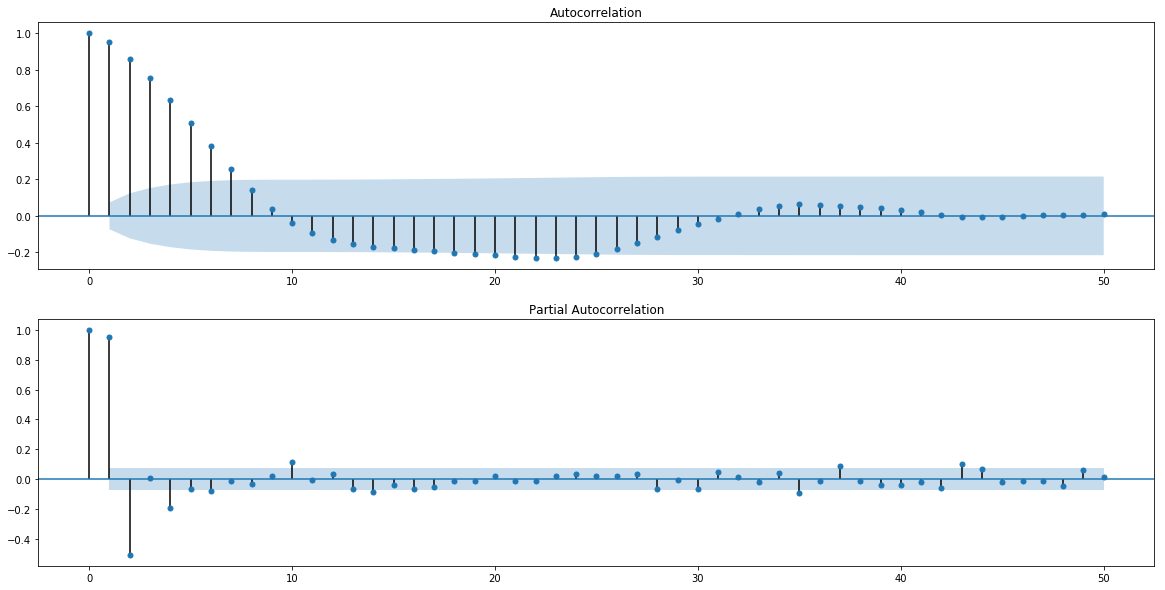

In [83]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ensorange.ANOM, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ensorange.ANOM, lags=50, ax=ax[1])
plt.show()

#### Sunspot observations

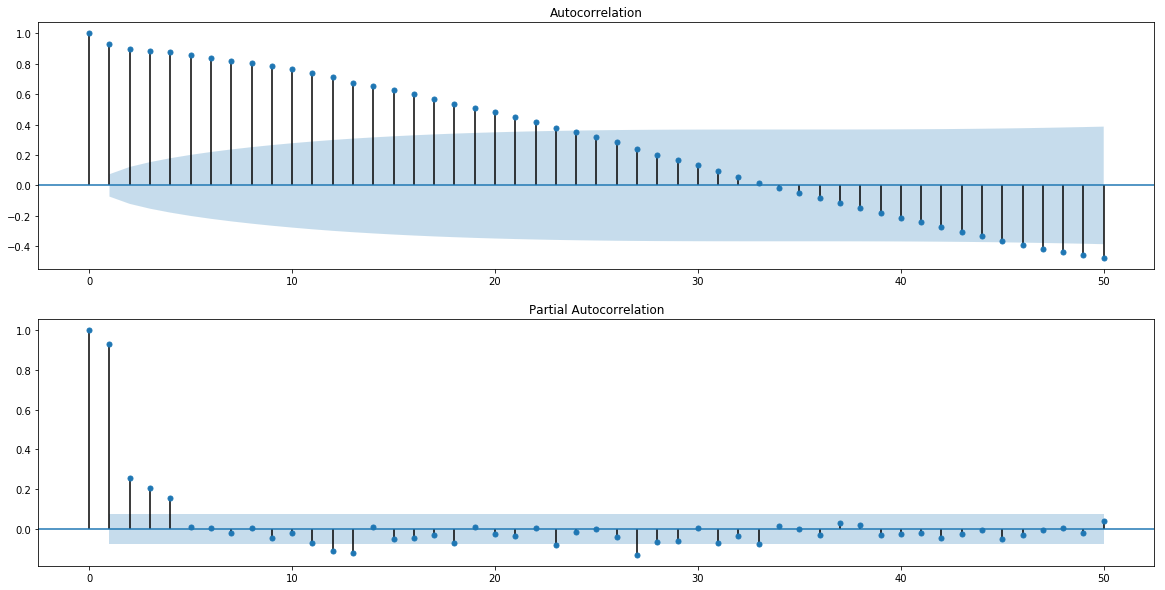

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(spotsrange.SNvalue, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(spotsrange.SNvalue, lags=50, ax=ax[1])
plt.show()

### Train/Test-split

In [85]:
tr_start,tr_end = '1960-01-01','2012-12-01'
te_start,te_end = '2013-01-01','2018-12-01'

train_anomaly, test_anomaly = anomalyrange[tr_start : tr_end], anomalyrange[te_start:te_end]
train_co2, test_co2 = co2range[tr_start : tr_end], co2range[te_start: te_end]
train_enso, test_enso = ensorange[tr_start : tr_end], ensorange[te_start: te_end]
train_spots, test_spots = spotsrange[tr_start : tr_end], spotsrange[te_start: te_end]
train_exogenous, test_exogenous = exogenous[tr_start : tr_end], exogenous[te_start: te_end]


### Gridsearch Hyperparameter selection

Gridsearch parameter selection, does not  support exogenous information. Was used to find parameter fo temperature anomaly and co2. Extremely slow to run so auto.arima (port from R) was used in finding other hypeparameters.

SARIMA-gridsearch code from:
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


format gridsearch.py filename.csv. You need to edit the sys.argv[1] parameter in to run these commands


In [ ]:
%run -i gridsearch.py anomalyrange.csv

In [23]:
#Best parameters for anomaly:
#[(2, 1, 2), (0, 0, 0, 0), 'c'] mse: 0.16167729212744297 on test set

In [ ]:
%run -i gridsearch.py co2range.csv

In [ ]:
#Best for co2range 
#[(1, 1, 0), (2, 1, 2, 12), 'ct'] 0.39512514162700024 FINAL PREDICTION FOR CO2
#[(0, 1, 1), (1, 1, 2, 12), 'ct'] 0.39795238942074973 
#[(0, 1, 2), (1, 1, 2, 12), 'ct'] 0.39798518063304383

In [ ]:
%run -i gridsearch.py ensorange.csv

In [ ]:
%run -i gridsearch.py spotsrange.csv

## Auto.arima

#### Temperature anomaly

In [24]:
#Lowest aic with no season (THIS WAS USED IN THE FINAL FORECAST):
#Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.471 seconds
#Lowest aic with season 12:
#Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=-927.767, BIC=-887.857, Fit time=22.331 second

In [87]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-976.078, BIC=-958.263, Fit time=0.166 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-837.431, BIC=-828.524, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-947.296, BIC=-933.935, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-973.847, BIC=-960.487, Fit time=0.037 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.471 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-952.895, BIC=-935.080, Fit time=0.070 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-1001.926, BIC=-975.205, Fit time=0.672 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-1001.982, BIC=-970.806, Fit time=0.780 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-1003.995, BIC=-977.273, Fit time=0.688 seconds
Total fit time: 2.919 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 507.955
Method:                       css-mle   S.D. of innovations              0.108
Date:                Sun, 17 Feb 2019   AIC                          -1005.910
Time:                        18:18:26   BIC                           -983.642
Sample:                             1   HQIC                          -997.264
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   8.19e-05     15.269      0.000       0.001       0.001
ar.L1.D.y      0.4571      0.038     11.900      0.000       0.382       0.532
ar.L2.D.y      0.2618      0.039      6.793      0.000       0.186       0.337
ma.L1.D.y     -1.0000      0.006   -171.880      0.000      -1.011      -0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2675           +0.0000j            1.2675            0.0000
AR.2           -3.0135           +0.0000j            3.0135            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-666.558, BIC=-648.744, Fit time=0.171 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-504.187, BIC=-495.279, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-625.240, BIC=-611.879, Fit time=0.021 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-662.778, BIC=-649.417, Fit time=0.032 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-690.002, BIC=-667.734, Fit time=0.459 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-634.120, BIC=-616.306, Fit time=0.060 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-688.428, BIC=-661.707, Fit time=0.526 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-687.084, BIC=-655.908, Fit time=0.743 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-688.410, BIC=-661.689, Fit time=0.687 seconds
Total fit time: 2.706 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 350.001
Method:                       css-mle   S.D. of innovations              0.139
Date:                Sun, 17 Feb 2019   AIC                           -690.002
Time:                        12:42:08   BIC                           -667.734
Sample:                             1   HQIC                          -681.356
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   9.49e-05     17.346      0.000       0.001       0.002
ar.L1.D.y      0.4249      0.038     11.074      0.000       0.350       0.500
ar.L2.D.y      0.2634      0.039      6.832      0.000       0.188       0.339
ma.L1.D.y     -1.0000      0.006   -163.985      0.000      -1.012      -0.988
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3023           +0.0000j            1.3023            0.0000
AR.2           -2.9156           +0.0000j            2.9156            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Temperature anomaly with co2

In [ ]:
#Lowest aic with no season:
#Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.456 seconds

In [88]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          exog=train_co2,
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-976.078, BIC=-958.263, Fit time=0.136 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-837.431, BIC=-828.524, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-947.296, BIC=-933.935, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-973.847, BIC=-960.487, Fit time=0.037 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.456 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-952.895, BIC=-935.080, Fit time=0.064 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-1001.926, BIC=-975.205, Fit time=0.671 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-1001.982, BIC=-970.806, Fit time=0.775 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-1003.995, BIC=-977.273, Fit time=0.672 seconds
Total fit time: 2.842 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 507.955
Method:                       css-mle   S.D. of innovations              0.108
Date:                Sun, 17 Feb 2019   AIC                          -1005.910
Time:                        18:18:59   BIC                           -983.642
Sample:                             1   HQIC                          -997.264
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   8.19e-05     15.269      0.000       0.001       0.001
ar.L1.D.y      0.4571      0.038     11.900      0.000       0.382       0.532
ar.L2.D.y      0.2618      0.039      6.793      0.000       0.186       0.337
ma.L1.D.y     -1.0000      0.006   -171.880      0.000      -1.011      -0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2675           +0.0000j            1.2675            0.0000
AR.2           -3.0135           +0.0000j            3.0135            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          exog=train_co2,
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-608.660, BIC=-586.487, Fit time=12.855 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-52.071, BIC=-43.202, Fit time=0.173 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-415.457, BIC=-397.719, Fit time=2.886 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-609.128, BIC=-591.389, Fit time=9.714 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-608.560, BIC=-586.387, Fit time=12.996 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-212.633, BIC=-199.330, Fit time=0.513 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-608.246, BIC=-586.073, Fit time=18.264 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-609.022, BIC=-582.415, Fit time=27.076 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-442.094, BIC=-428.791, Fit time=5.421 seconds
Fit ARIMA: order=(0, 1, 2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  636
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 308.564
Date:                            Sun, 17 Feb 2019   AIC                           -609.128
Time:                                    14:55:39   BIC                           -591.389
Sample:                                         0   HQIC                          -602.234
                                            - 636                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.412e-05      0.000      0.092      0.926      -0.000       0.000
ma.L1         -0.5933      0.033    -17.917      0.000      -0.658      -0.528
ma.S.L12      -0.9955      0.162     -6.139      0.000      -1.313      -0.678
sigma2         0.0202      0.003      6.408      0.000       0.014       0.026
===================================================================================
Ljung-Box (Q):                       53.98   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.07   Prob(JB):                         0.34
Heteroskedasticity (H):               1.03   Skew:                             0.12
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Temperature anomaly with all exogenous variables

In [ ]:
#Lowest aic with no season:
#Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.453 seconds

In [89]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          exog=train_exogenous,
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-976.078, BIC=-958.263, Fit time=0.140 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-837.431, BIC=-828.524, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-947.296, BIC=-933.935, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-973.847, BIC=-960.487, Fit time=0.038 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-1005.910, BIC=-983.642, Fit time=0.453 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-952.895, BIC=-935.080, Fit time=0.048 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-1001.926, BIC=-975.205, Fit time=0.642 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-1001.982, BIC=-970.806, Fit time=0.798 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-1003.995, BIC=-977.273, Fit time=0.650 seconds
Total fit time: 2.800 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 507.955
Method:                       css-mle   S.D. of innovations              0.108
Date:                Sun, 17 Feb 2019   AIC                          -1005.910
Time:                        18:20:46   BIC                           -983.642
Sample:                             1   HQIC                          -997.264
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   8.19e-05     15.269      0.000       0.001       0.001
ar.L1.D.y      0.4571      0.038     11.900      0.000       0.382       0.532
ar.L2.D.y      0.2618      0.039      6.793      0.000       0.186       0.337
ma.L1.D.y     -1.0000      0.006   -171.880      0.000      -1.011      -0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2675           +0.0000j            1.2675            0.0000
AR.2           -3.0135           +0.0000j            3.0135            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [46]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          exog=train_exogenous,
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-608.660, BIC=-586.487, Fit time=12.660 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-52.071, BIC=-43.202, Fit time=0.183 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-415.457, BIC=-397.719, Fit time=2.870 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-609.128, BIC=-591.389, Fit time=9.762 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-608.560, BIC=-586.387, Fit time=13.356 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-212.633, BIC=-199.330, Fit time=0.515 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-608.246, BIC=-586.073, Fit time=18.417 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-609.022, BIC=-582.415, Fit time=27.102 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-442.094, BIC=-428.791, Fit time=5.374 seconds
Fit ARIMA: order=(0, 1, 2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  636
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 308.564
Date:                            Sun, 17 Feb 2019   AIC                           -609.128
Time:                                    15:00:52   BIC                           -591.389
Sample:                                         0   HQIC                          -602.234
                                            - 636                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.412e-05      0.000      0.092      0.926      -0.000       0.000
ma.L1         -0.5933      0.033    -17.917      0.000      -0.658      -0.528
ma.S.L12      -0.9955      0.162     -6.139      0.000      -1.313      -0.678
sigma2         0.0202      0.003      6.408      0.000       0.014       0.026
===================================================================================
Ljung-Box (Q):                       53.98   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.07   Prob(JB):                         0.34
Heteroskedasticity (H):               1.03   Skew:                             0.12
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### CO2 concentration

In [25]:
#Lowest aic seasonal:
#Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=259.844, BIC=282.017, Fit time=12.238 seconds

In [22]:
stepwise_fit = pm.auto_arima(train_co2, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=259.844, BIC=282.017, Fit time=12.238 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=666.394, BIC=675.264, Fit time=0.308 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=452.528, BIC=470.266, Fit time=2.270 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=262.332, BIC=280.070, Fit time=5.079 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=261.782, BIC=288.389, Fit time=14.361 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=595.137, BIC=612.875, Fit time=0.777 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=261.779, BIC=288.387, Fit time=17.160 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=263.656, BIC=294.698, Fit time=18.954 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=264.847, BIC=291.454, Fit time=13.434 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  636
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -124.922
Date:                            Sun, 17 Feb 2019   AIC                            259.844
Time:                                    12:45:12   BIC                            282.017
Sample:                                         0   HQIC                           268.461
                                            - 636                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.639      0.008       0.000       0.003
ar.L1          0.2379      0.097      2.450      0.014       0.048       0.428
ma.L1         -0.5905      0.083     -7.089      0.000      -0.754      -0.427
ma.S.L12      -0.8844      0.020    -44.202      0.000      -0.924      -0.845
sigma2         0.0849      0.005     17.817      0.000       0.076       0.094
===================================================================================
Ljung-Box (Q):                       42.48   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.36   Prob(JB):                         0.83
Heteroskedasticity (H):               1.27   Skew:                            -0.05
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### The Oceanic Niño Index (ONI)

In the final model we assume that el nino increases (constant c)

In [27]:
#Lowest aic no season:
#Fit ARIMA: order=(2, 1, 3); AIC=-40.419, BIC=-9.244, Fit time=0.441 seconds

In [26]:
stepwise_fit = pm.auto_arima(train_enso, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-18.625, BIC=-0.811, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 0); AIC=120.728, BIC=129.635, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-14.712, BIC=-1.351, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-16.222, BIC=-2.861, Fit time=0.024 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-19.930, BIC=2.338, Fit time=0.097 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-15.525, BIC=2.290, Fit time=0.038 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-21.142, BIC=5.580, Fit time=0.198 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-39.475, BIC=-3.846, Fit time=0.547 seconds
Fit ARIMA: order=(2, 1, 3); AIC=-40.419, BIC=-9.244, Fit time=0.441 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-21.262, BIC=1.006, Fit time=0.138 seconds
Fit ARIMA: order=(1, 1, 3); AIC=-22.198, BIC=4.524, Fit time=0.221 seconds
Total fit time: 1.818 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  27.210
Method:                       css-mle   S.D. of innovations              0.232
Date:                Sun, 17 Feb 2019   AIC                            -40.419
Time:                        12:51:14   BIC                             -9.244
Sample:                             1   HQIC                           -28.314
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.016     -0.076      0.940      -0.032       0.030
ar.L1.D.y      1.7603      0.047     37.733      0.000       1.669       1.852
ar.L2.D.y     -0.9153      0.042    -21.799      0.000      -0.998      -0.833
ma.L1.D.y     -1.2934      0.060    -21.381      0.000      -1.412      -1.175
ma.L2.D.y      0.2010      0.067      2.988      0.003       0.069       0.333
ma.L3.D.y      0.3585      0.044      8.199      0.000       0.273       0.444
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9616           -0.4098j            1.0453           -0.0641
AR.2            0.9616           +0.4098j            1.0453            0.0641
MA.1            0.9568           -0.4602j            1.0618           -0.0713
MA.2            0.9568           +0.4602j            1.0618            0.0713
MA.3           -2.4745           -0.0000j            2.4745           -0.5000
-----------------------------------------------------------------------------
"""

#### Sunspot observations

In [ ]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
#Lowest aic no season:
#Fit ARIMA: order=(2, 1, 2); AIC=5811.146, BIC=5837.868, Fit time=0.401 seconds
#Lowest aic 11 year season (follow approximately an 11 year season)
#Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 132); AIC=4934.675, BIC=4951.557, Fit time=408.381 seconds
#Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 132); AIC=4884.352, BIC=4905.455, Fit time=2357.197 seconds

In [30]:
stepwise_fit = pm.auto_arima(train_spots, start_p=1, start_q=1, max_p=3, max_q=3, m=12*11,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  

stepwise_fit.summary()

# Models on test data

## ARIMA model on temperature anomaly

In [90]:
sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,1),trend='c',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 506.581
Date:                Sun, 17 Feb 2019   AIC                          -1003.162
Time:                        18:21:40   BIC                           -980.910
Sample:                    01-01-1960   HQIC                          -994.521
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003    4.7e-05      7.414      0.000       0.000       0.000
ar.L1          0.4597      0.037     12.329      0.000       0.387       0.533
ar.L2          0.2642      0.038      7.034      0.000       0.191       0.338
ma.L1         -1.0001      0.345     -2.901      0.004      -1.676      -0.324
sigma2         0.0117      0.004      2.855      0.004       0.004       0.020
===================================================================================
Ljung-Box (Q):                       49.20   Jarque-Bera (JB):                 6.98
Prob(Q):                              0.15   Prob(JB):                         0.03
Heteroskedasticity (H):               1.00   Skew:                             0.22
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.035556732068484434


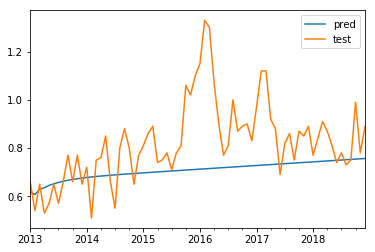

In [91]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

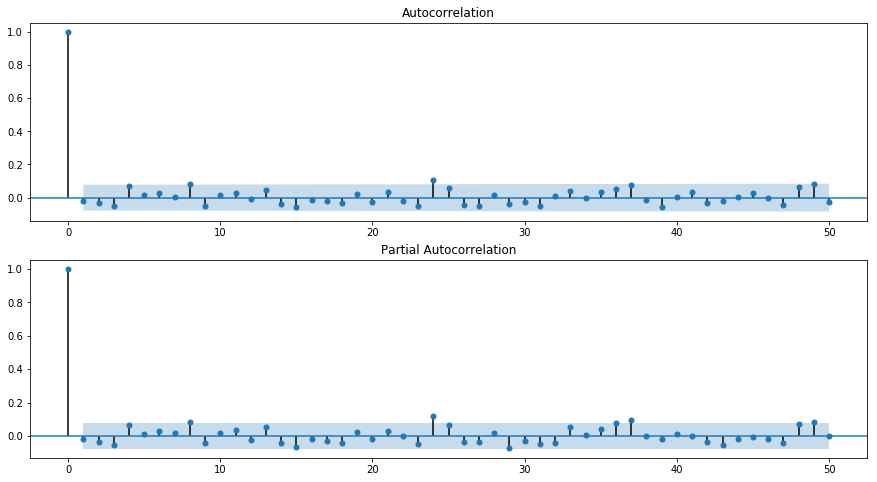

In [92]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

### SARIMAX-model with CO2 as exogenous data

In [93]:
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,1),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_co2).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 507.073
Date:                Sun, 17 Feb 2019   AIC                          -1002.146
Time:                        18:21:59   BIC                           -975.443
Sample:                    01-01-1960   HQIC                          -991.776
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.767      0.077   -2.19e-05       0.000
CO2filled      0.0046      0.003      1.463      0.144      -0.002       0.011
ar.L1          0.4517      0.038     12.018      0.000       0.378       0.525
ar.L2          0.2553      0.038      6.684      0.000       0.180       0.330
ma.L1         -1.0000      2.200     -0.455      0.649      -5.311       3.311
sigma2         0.0117      0.026      0.454      0.649      -0.039       0.062
===================================================================================
Ljung-Box (Q):                       50.12   Jarque-Bera (JB):                 5.13
Prob(Q):                              0.13   Prob(JB):                         0.08
Heteroskedasticity (H):               1.03   Skew:                             0.19
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.027727907349669588


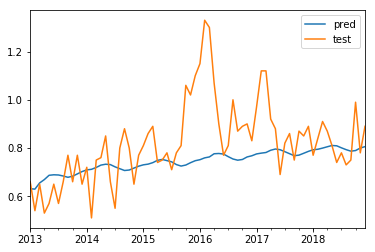

In [94]:
pred = sarimax.predict(tr_end,te_end,exog=test_co2)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

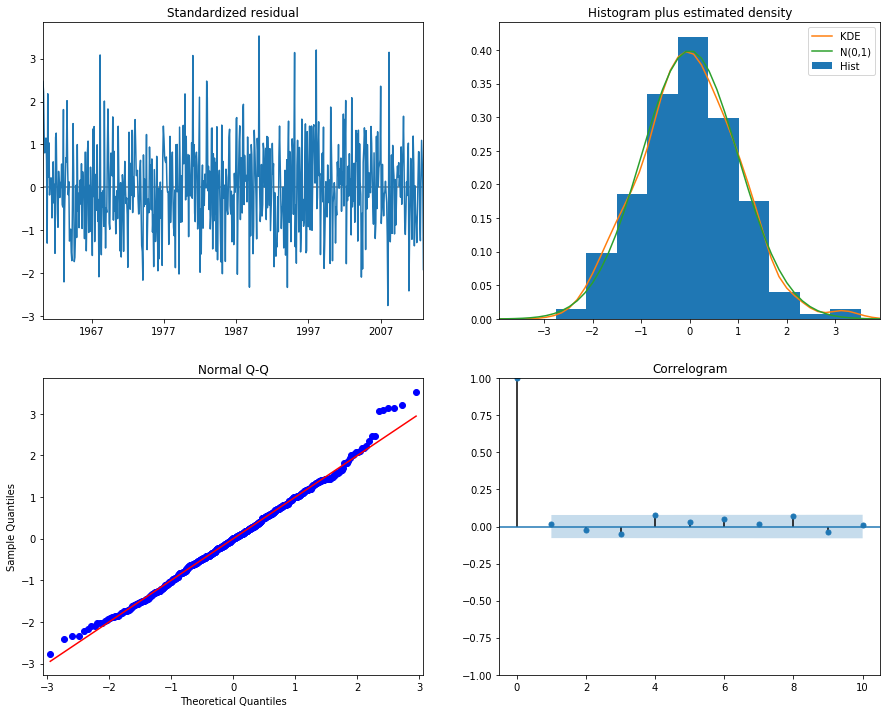

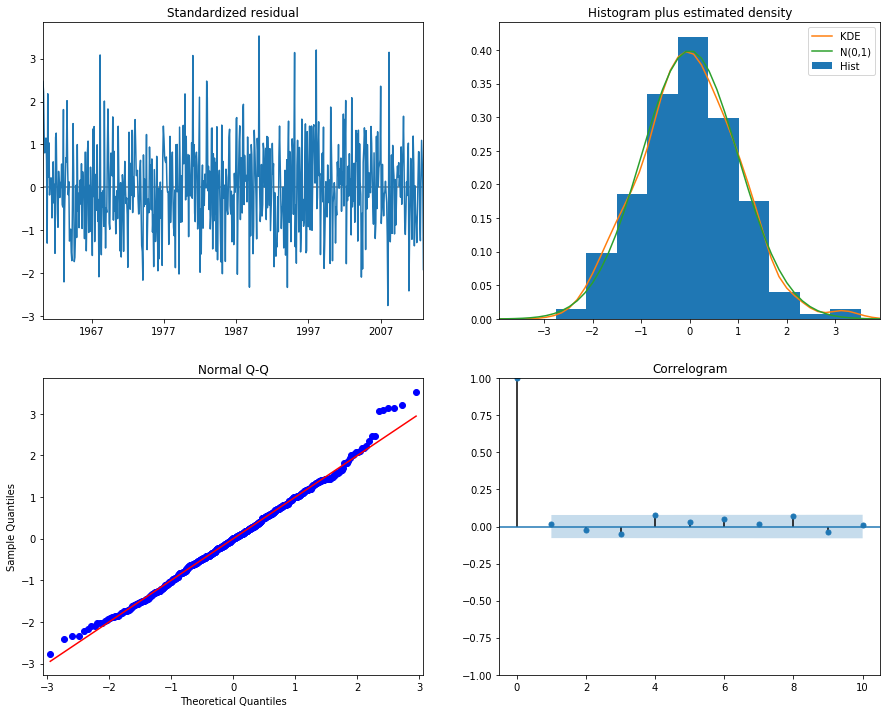

In [95]:
sarimax.plot_diagnostics(figsize=(15, 12))

### SARIMAX-model with all Exogenous data

In [96]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,1),trend='c',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_exogenous).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 505.697
Date:                Sun, 17 Feb 2019   AIC                           -995.394
Time:                        18:22:20   BIC                           -959.790
Sample:                    01-01-1960   HQIC                          -981.567
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.002      0.449      0.653      -0.002       0.004
CO2filled      0.0038      0.003      1.429      0.153      -0.001       0.009
ANOM           0.0485      0.012      4.023      0.000       0.025       0.072
SNvalue     4.164e-05      0.000      0.213      0.831      -0.000       0.000
ar.L1          0.1456      0.081      1.789      0.074      -0.014       0.305
ar.L2          0.0183      0.058      0.315      0.753      -0.096       0.132
ma.L1         -1.4947      0.174     -8.604      0.000      -1.835      -1.154
sigma2         0.0053      0.001      4.240      0.000       0.003       0.008
===================================================================================
Ljung-Box (Q):                       62.17   Jarque-Bera (JB):                 3.39
Prob(Q):                              0.01   Prob(JB):                         0.18
Heteroskedasticity (H):               1.03   Skew:                             0.16
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Predictable adding noisy data did not improve the model over co2

SARIMA model MSE:0.03210886420490155


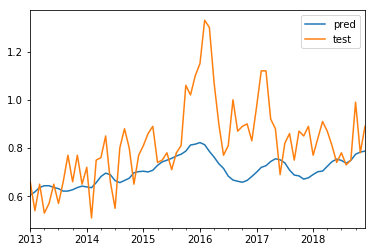

In [97]:
pred = sarimax.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

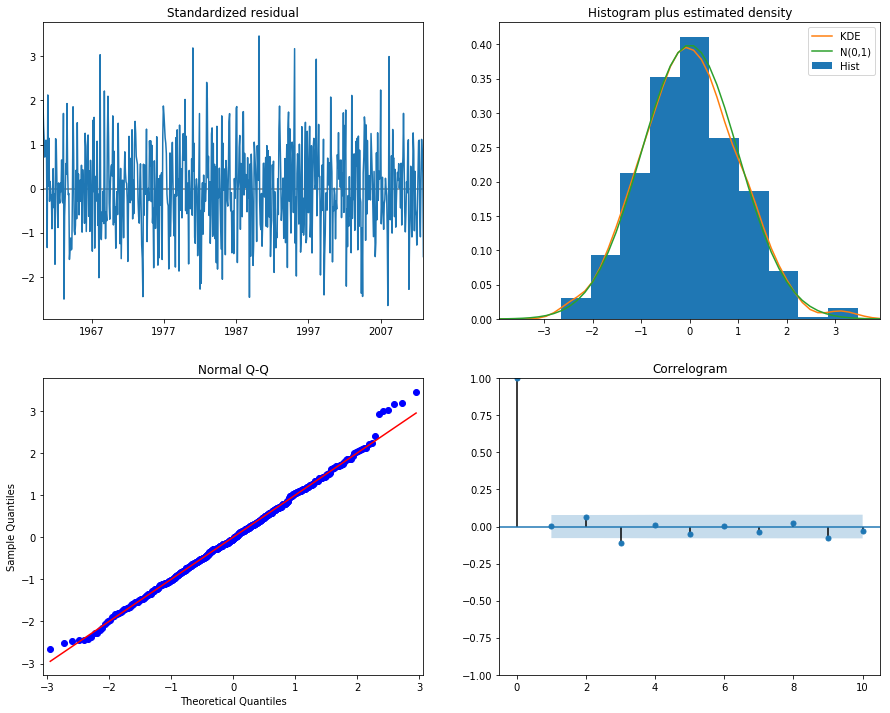

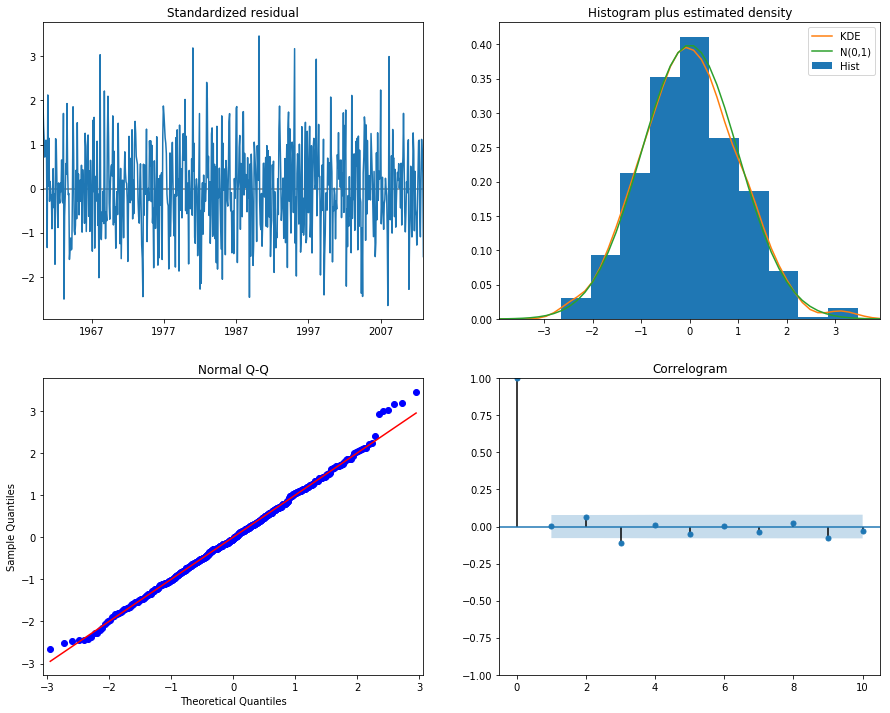

In [98]:
sarimax.plot_diagnostics(figsize=(15, 12))

# Final predictions

## ARIMA-prediction

In [152]:
mod = sm.tsa.statespace.SARIMAX(anomalyrange.anomaly,order=(2,1,1),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 551.685
Date:                Sun, 17 Feb 2019   AIC                          -1093.370
Time:                        19:36:30   BIC                          -1070.579
Sample:                    01-01-1960   HQIC                         -1084.563
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.847      0.397      -0.001       0.003
ar.L1          0.2751      0.062      4.458      0.000       0.154       0.396
ar.L2      -4.051e-06      0.003     -0.001      0.999      -0.006       0.006
ma.L1         -1.3553      0.078    -17.297      0.000      -1.509      -1.202
sigma2         0.0067      0.001      7.815      0.000       0.005       0.008
===================================================================================
Ljung-Box (Q):                       73.72   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               1.06   Skew:                             0.14
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
prediction1 = res.get_forecast(steps=373)

In [154]:
prediction1.predicted_mean.tail()

2049-09-01    1.327912
2049-10-01    1.329212
2049-11-01    1.330512
2049-12-01    1.331812
2050-01-01    1.333112
Freq: MS, dtype: float64

In [156]:
pred_ci1 = prediction1.conf_int()

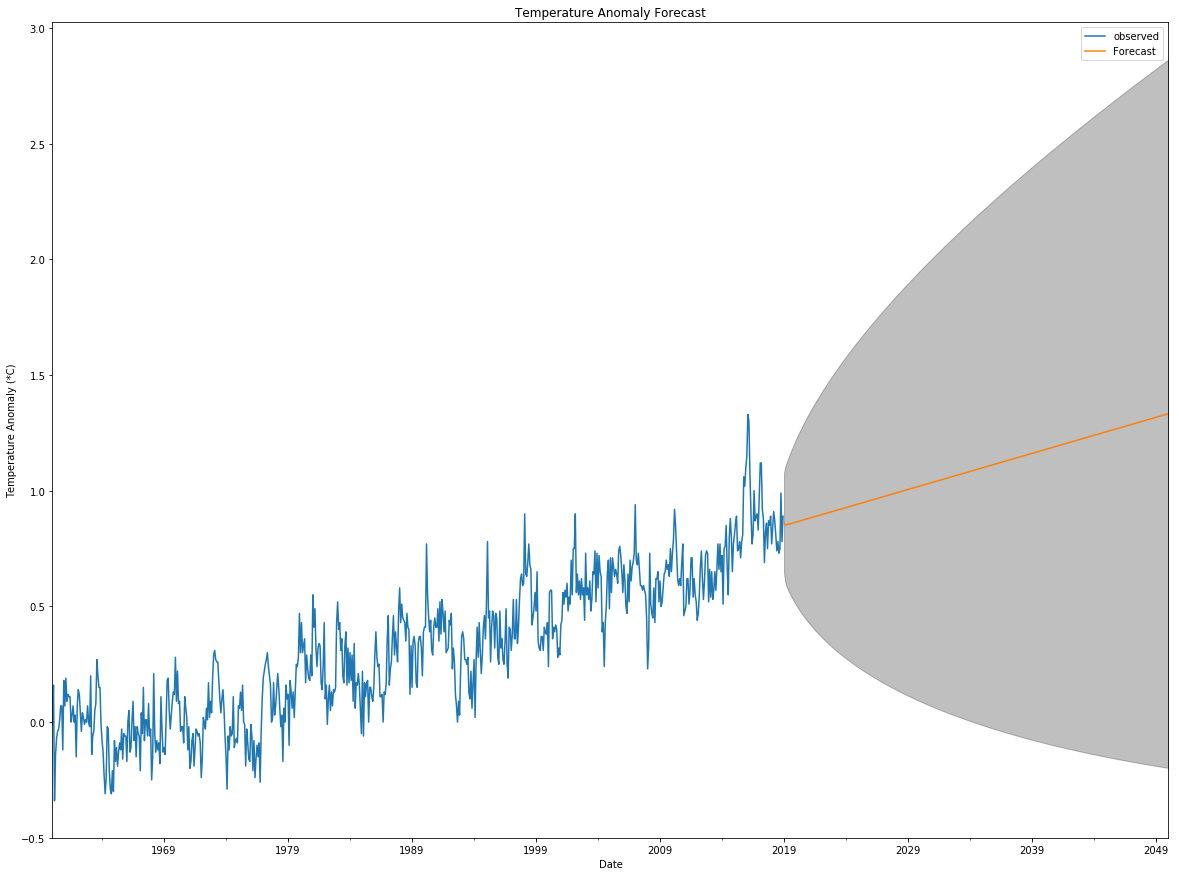

In [157]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Temperature Anomaly Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()

In [147]:
prediction1.predicted_mean.to_csv('predictions/anomalyonly_2050.csv')

### SARIMAX-prediction with CO2

#### Generate future prediction of co2 concentration

In [105]:
co2sarima = sm.tsa.statespace.SARIMAX(co2range,order=(1,1,0),trend='ct', seasonal_order=(2,1,2,12),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

co2sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          CO2filled   No. Observations:                  708
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood                -217.024
Date:                            Sun, 17 Feb 2019   AIC                            450.048
Time:                                    18:24:16   BIC                            486.107
Sample:                                01-01-1960   HQIC                           464.015
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032      0.018      0.174      0.862      -0.033       0.039
drift         1.5e-06   4.09e-05      0.037      0.971   -7.87e-05    8.17e-05
ar.L1         -0.3243      0.058     -5.623      0.000      -0.437      -0.211
ar.S.L12      -0.4953      0.430     -1.151      0.250      -1.339       0.348
ar.S.L24      -0.0076      0.066     -0.114      0.909      -0.137       0.122
ma.S.L12      -0.3018      0.435     -0.694      0.487      -1.154       0.550
ma.S.L24      -0.3648      0.336     -1.085      0.278      -1.024       0.294
sigma2         0.1667      0.013     12.397      0.000       0.140       0.193
===================================================================================
Ljung-Box (Q):                       52.91   Jarque-Bera (JB):                 1.96
Prob(Q):                              0.08   Prob(JB):                         0.37
Heteroskedasticity (H):               1.59   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
co2pred   = co2sarima.get_forecast(steps=373)

In [159]:
co2pred.predicted_mean.tail()

2049-09-01    496.628378
2049-10-01    497.045258
2049-11-01    498.921222
2049-12-01    500.351163
2050-01-01    501.668269
Freq: MS, dtype: float64

In [162]:
pred_ci = co2pred.conf_int()

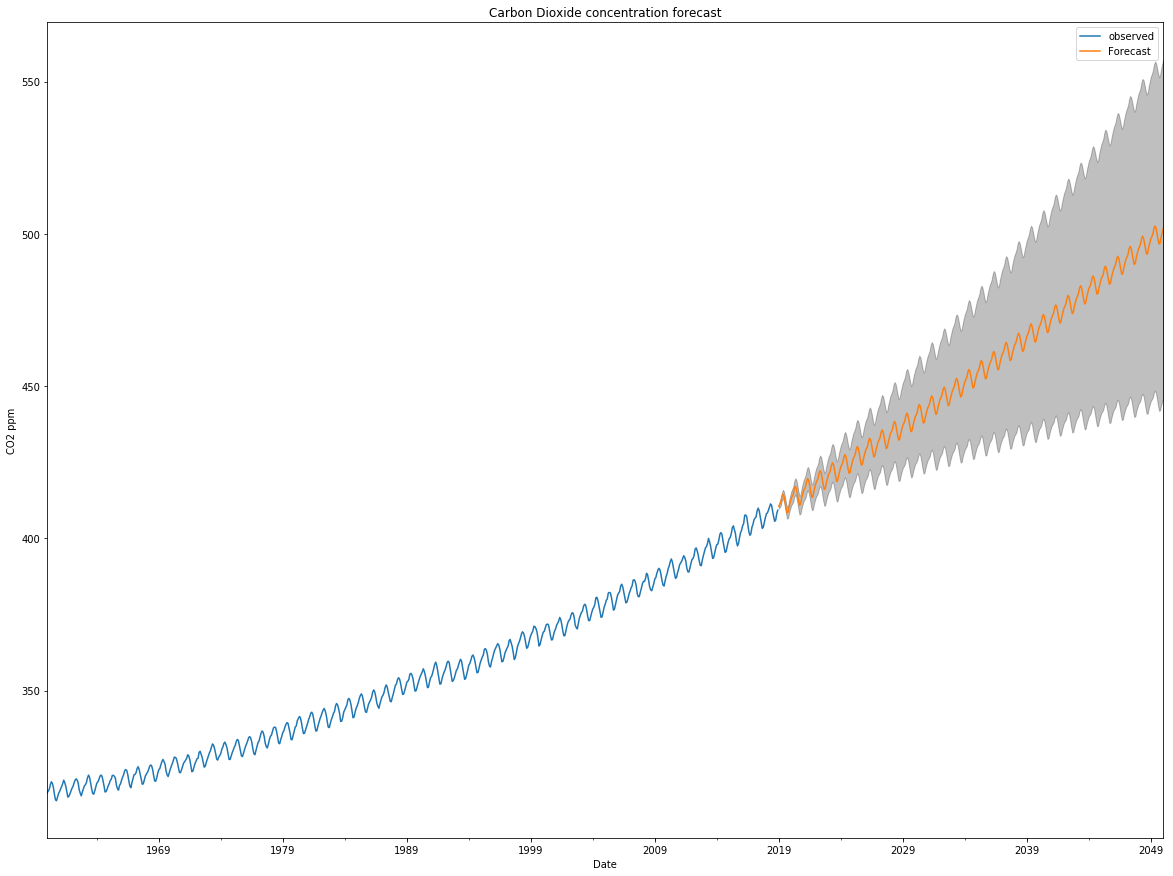

In [163]:
ax = co2range.CO2filled.plot(label='observed', figsize=(20, 15))
co2pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Carbon Dioxide concentration forecast')
ax.set_xlabel('Date')
ax.set_ylabel('CO2 ppm')

plt.legend()
plt.show()

#### Prediction with co2 as exogenous variable

In [134]:
mod = sm.tsa.statespace.SARIMAX(anomalyrange.anomaly,order=(2,1,1),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=co2range.values)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 549.765
Date:                Sun, 17 Feb 2019   AIC                          -1087.531
Time:                        19:20:02   BIC                          -1060.181
Sample:                    01-01-1960   HQIC                         -1076.962
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.002      0.529      0.597      -0.003       0.005
x1             0.0019      0.003      0.763      0.446      -0.003       0.007
ar.L1          0.0827      0.077      1.075      0.283      -0.068       0.234
ar.L2      -4.747e-06      0.004     -0.001      0.999      -0.009       0.009
ma.L1         -1.7989      0.208     -8.666      0.000      -2.206      -1.392
sigma2         0.0038      0.001      4.311      0.000       0.002       0.006
===================================================================================
Ljung-Box (Q):                       72.61   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               1.10   Skew:                             0.14
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
prediction2 = res.get_forecast(steps=373, exog=co2pred.predicted_mean.reshape(373,1))

In [136]:
prediction2.predicted_mean.tail()

2049-09-01    1.454571
2049-10-01    1.456533
2049-11-01    1.461332
2049-12-01    1.465264
2050-01-01    1.468976
Freq: MS, dtype: float64

In [164]:
pred_ci2 = prediction2.conf_int()

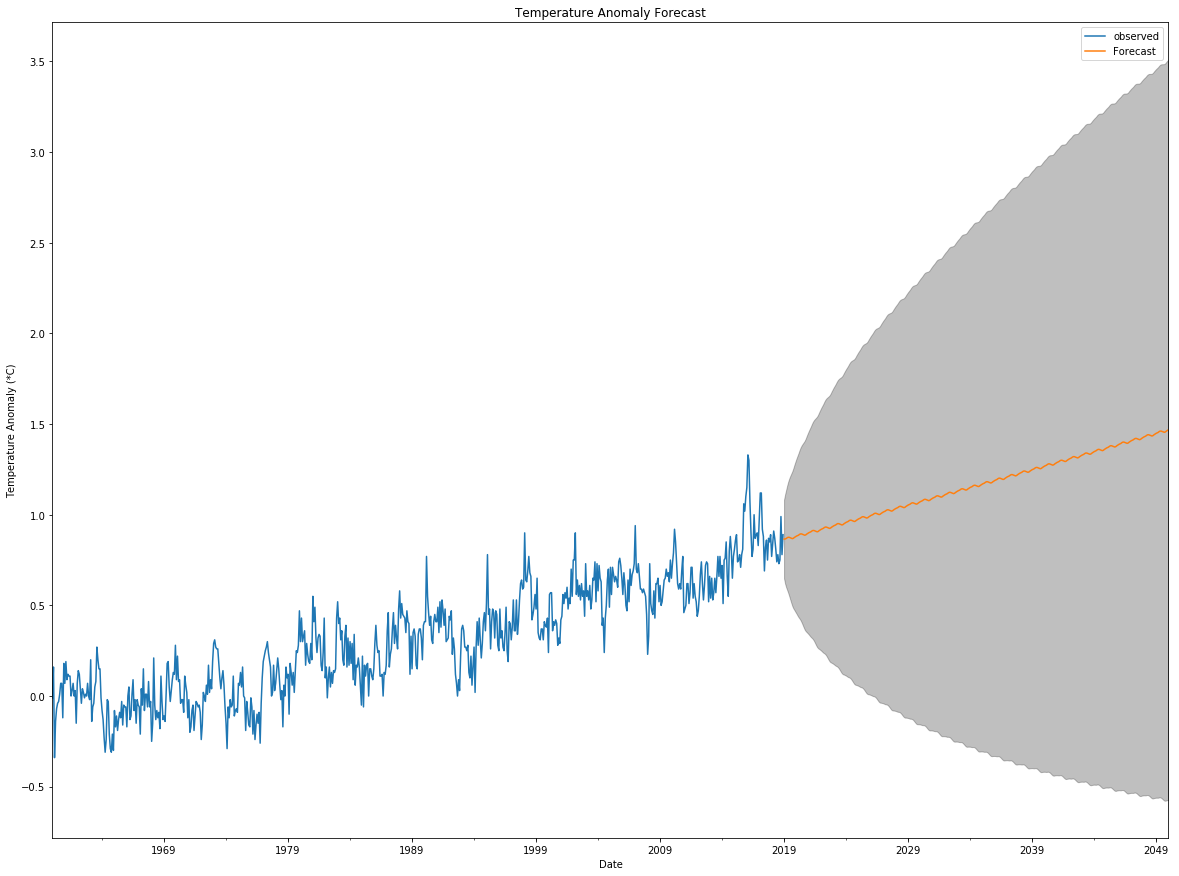

In [165]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Temperature Anomaly Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()

In [139]:
prediction2.predicted_mean.to_csv('predictions/co2_exogenous_2050.csv')

## SARIMAX-prediction with all exogenous variable

In [116]:
ensosarima = sm.tsa.statespace.SARIMAX(ensorange,order=(2,1,3),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

ensosarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   ANOM   No. Observations:                  708
Model:               SARIMAX(2, 1, 3)   Log Likelihood                  39.669
Date:                Sun, 17 Feb 2019   AIC                            -65.338
Time:                        18:25:15   BIC                            -33.451
Sample:                    01-01-1960   HQIC                           -53.014
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.003      0.094      0.925      -0.005       0.005
ar.L1          1.7281      0.050     34.348      0.000       1.629       1.827
ar.L2         -0.8947      0.047    -19.200      0.000      -0.986      -0.803
ma.L1         -1.2457      0.062    -19.988      0.000      -1.368      -1.124
ma.L2          0.1799      0.061      2.938      0.003       0.060       0.300
ma.L3          0.3646      0.040      9.092      0.000       0.286       0.443
sigma2         0.0521      0.003     20.242      0.000       0.047       0.057
===================================================================================
Ljung-Box (Q):                       47.68   Jarque-Bera (JB):                 6.13
Prob(Q):                              0.19   Prob(JB):                         0.05
Heteroskedasticity (H):               0.60   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
ensopred = ensosarima.get_forecast(steps=373)
pred_ci = ensopred.conf_int()
ensopred.predicted_mean.tail()

2049-09-01    1.357523
2049-10-01    1.359013
2049-11-01    1.360502
2049-12-01    1.361991
2050-01-01    1.363480
Freq: MS, dtype: float64

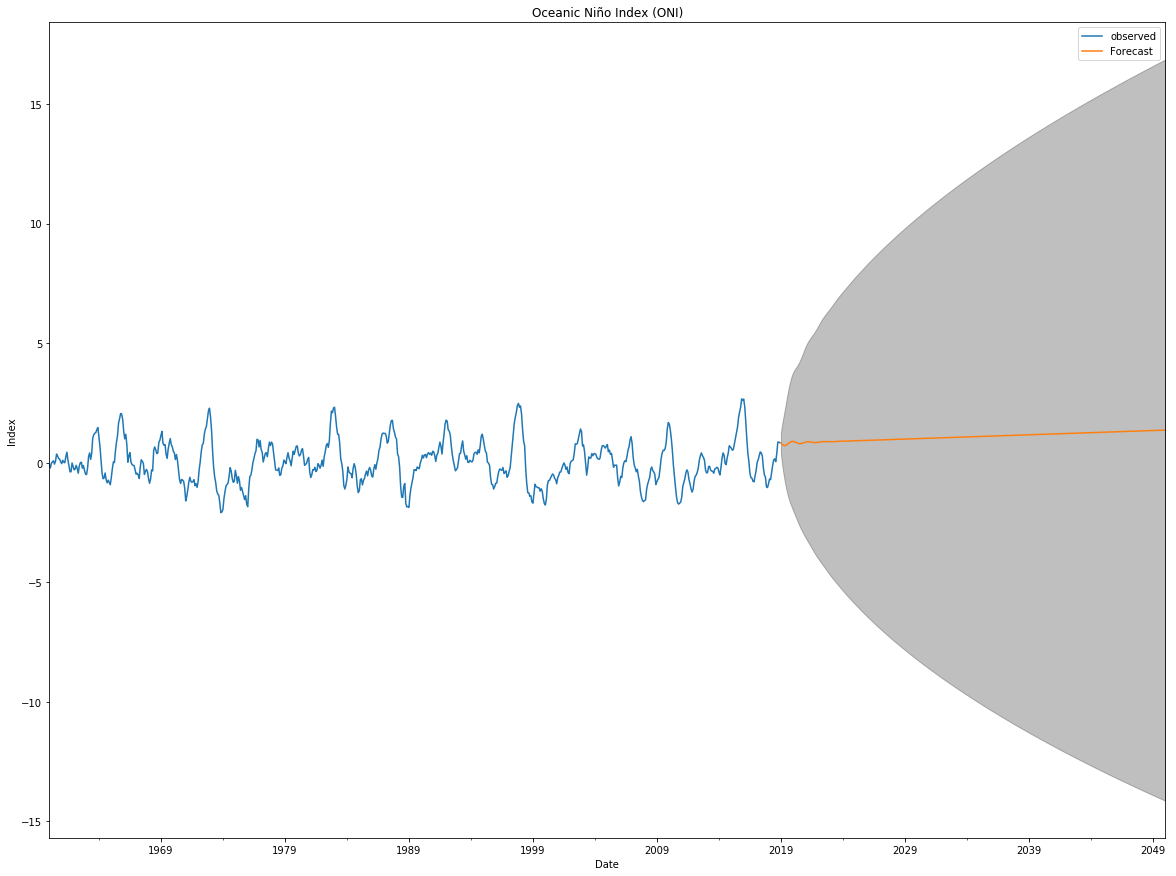

In [118]:
ax = ensorange.ANOM.plot(label='observed', figsize=(20, 15))
ensopred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Oceanic Niño Index (ONI)')
ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()

In [123]:
# Eleven year cycle takes long time to calculate
sunspotsarima = sm.tsa.statespace.SARIMAX(spotsrange,order=(1,1,0),trend='ct', seasonal_order=(2,1,0,11*12),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

sunspotsarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                             SNvalue   No. Observations:                  708
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 132)   Log Likelihood               -1453.395
Date:                             Sun, 17 Feb 2019   AIC                           2918.790
Time:                                     19:03:59   BIC                           2941.209
Sample:                                 01-01-1960   HQIC                          2927.752
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3269     10.248      0.032      0.975     -19.759      20.413
drift         -0.0004      0.019     -0.019      0.985      -0.038       0.037
ar.L1         -0.2795      0.046     -6.015      0.000      -0.371      -0.188
ar.S.L132     -0.7458      0.039    -19.309      0.000      -0.822      -0.670
ar.S.L264     -0.4053      0.043     -9.516      0.000      -0.489      -0.322
sigma2       691.5005     47.368     14.599      0.000     598.662     784.339
===================================================================================
Ljung-Box (Q):                       87.82   Jarque-Bera (JB):                16.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
spotspred = sunspotsarima.get_forecast(steps=373)
pred_ci = spotspred.conf_int()
spotspred.predicted_mean.tail()

2049-09-01    29.120319
2049-10-01    21.011728
2049-11-01    11.114743
2049-12-01    17.464701
2050-01-01    12.764906
Freq: MS, dtype: float64

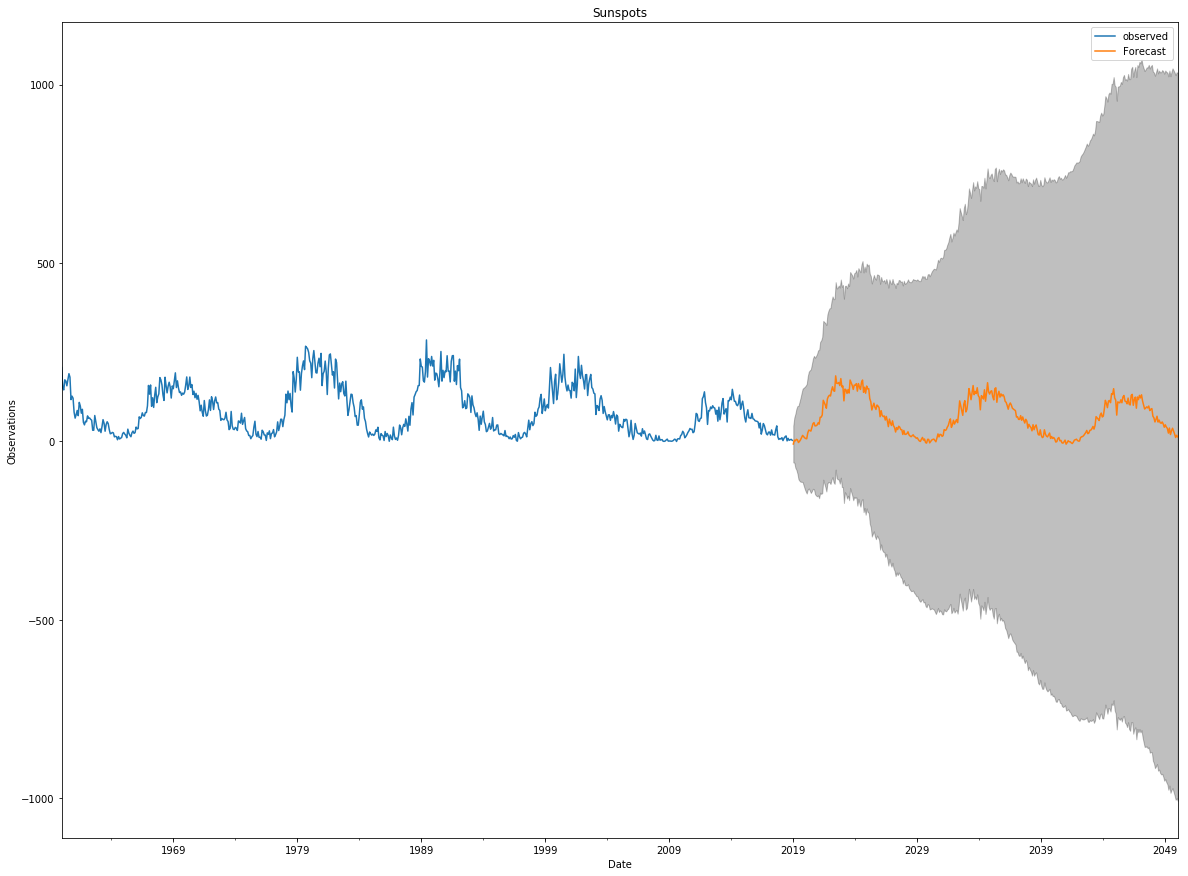

In [125]:
ax = spotsrange.SNvalue.plot(label='observed', figsize=(20, 15))
spotspred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Sunspots')
ax.set_xlabel('Date')
ax.set_ylabel('Observations')

plt.legend()
plt.show()

In [168]:
exogenouspred = pd.concat([co2pred.predicted_mean,ensopred.predicted_mean,spotspred.predicted_mean], axis=1)

In [169]:
mod = sm.tsa.statespace.SARIMAX(anomalyrange.anomaly,order=(2,1,2),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=exogenous)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 572.311
Date:                Sun, 17 Feb 2019   AIC                          -1126.621
Time:                        19:38:33   BIC                          -1085.610
Sample:                    01-01-1960   HQIC                         -1110.772
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.769      0.442      -0.001       0.003
CO2filled      0.0029      0.003      1.039      0.299      -0.003       0.008
ANOM           0.0535      0.011      4.949      0.000       0.032       0.075
SNvalue      7.19e-05      0.000      0.402      0.687      -0.000       0.000
ar.L1         -0.3316      0.151     -2.196      0.028      -0.628      -0.036
ar.L2          0.3085      0.052      5.953      0.000       0.207       0.410
ma.L1         -0.2011      0.152     -1.323      0.186      -0.499       0.097
ma.L2         -0.5348      0.111     -4.815      0.000      -0.752      -0.317
sigma2         0.0115      0.001     19.367      0.000       0.010       0.013
===================================================================================
Ljung-Box (Q):                       53.53   Jarque-Bera (JB):                 4.88
Prob(Q):                              0.07   Prob(JB):                         0.09
Heteroskedasticity (H):               0.99   Skew:                             0.18
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [170]:
prediction3 = res.get_forecast(steps=373, exog=exogenouspred)
pred_ci3 = prediction3.conf_int()
prediction3.predicted_mean.tail()

2049-09-01    1.492050
2049-10-01    1.493666
2049-11-01    1.499327
2049-12-01    1.504880
2050-01-01    1.509315
Freq: MS, dtype: float64

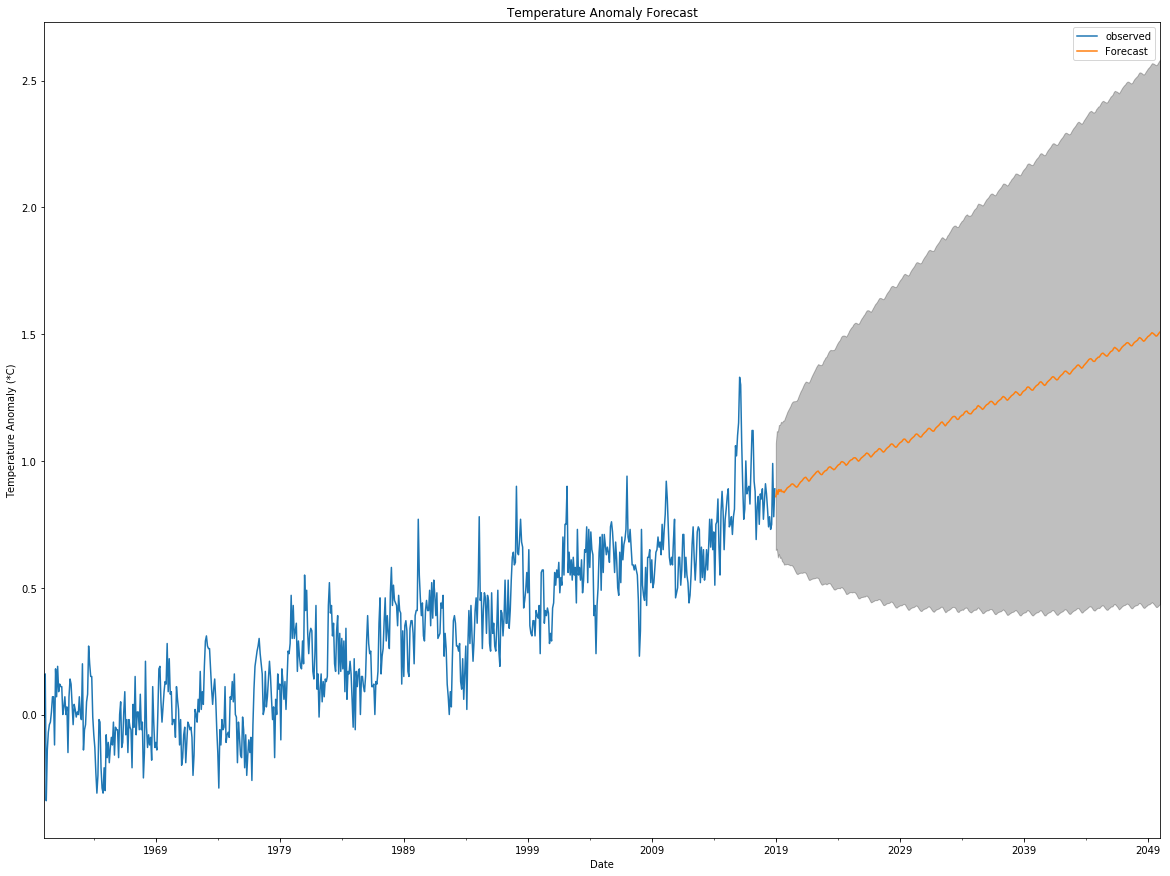

In [171]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction3.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Temperature Anomaly Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()

In [133]:
prediction3.predicted_mean.to_csv('predictions/all_exogenous_2050.csv')

### All predictions 

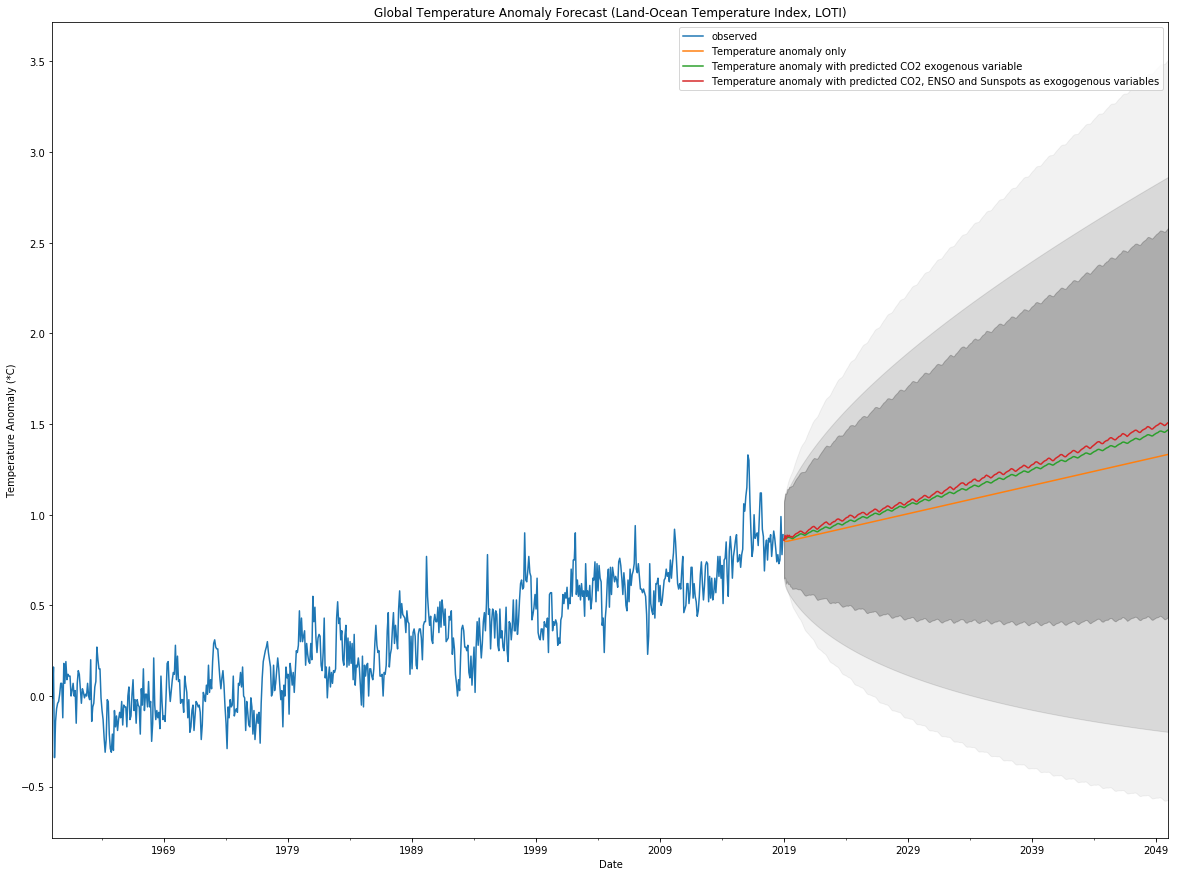

In [186]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction1.predicted_mean.plot(ax=ax, label='Temperature anomaly only')
prediction2.predicted_mean.plot(ax=ax, label='Temperature anomaly with predicted CO2 exogenous variable')
prediction3.predicted_mean.plot(ax=ax, label='Temperature anomaly with predicted CO2, ENSO and Sunspots as exogogenous variables')

ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=0.1)

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=0.05)

ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=0.2)


ax.set_title('Global Temperature Anomaly Forecast (Land-Ocean Temperature Index, LOTI)')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()
